# Natural Language Processing with Disaster Tweets

## Introduction
In this project, we aim to build a machine learning model that can predict whether a given tweet is about a real disaster or not. This task involves natural language processing (NLP) techniques and deep learning using BERT, a state-of-the-art transformer model.

## Dataset
The dataset consists of 10,000 tweets that have been hand-labeled as either being about a real disaster (1) or not (0). The data is split into training and test sets.

## Evaluation
Submissions are evaluated using the F1 score between the predicted and expected answers. The F1 score is calculated as follows:

$$ F1 = 2 * \\frac{precision * recall}{precision + recall} $$

Where precision and recall are defined as:

$$ precision = \\frac{TP}{TP + FP} $$
$$ recall = \\frac{TP}{TP + FN} $$

True Positive (TP), False Positive (FP), and False Negative (FN) are defined based on the comparison between the predicted and actual labels.


## Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset

# Download NLTK data
nltk.download('stopwords')

# Load the datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Display the first few rows of the train dataset
print(train_data.head())

# Display the first few rows of the test dataset
print(test_data.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuel.lausten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Text Length Analysis
Let's analyze the length of the tweets to understand their distribution.

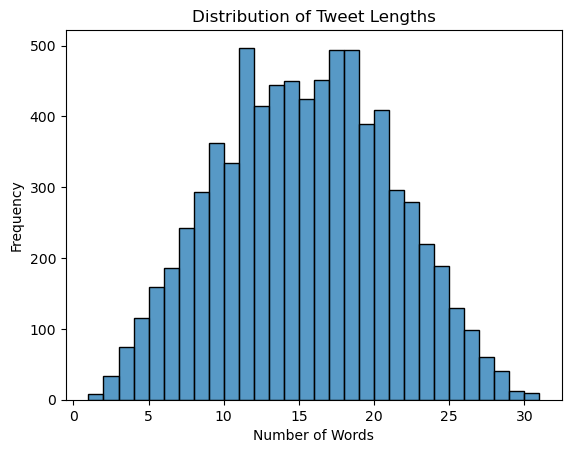

In [3]:
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['text_length'], bins=30)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


### Experiment 1: Logistic Regression

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score


# Function to clean text data
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)  # Remove special characters
    text = text.strip()  # Remove leading and trailing whitespace
    return text

# Apply text cleaning
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=2, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(train_data['cleaned_text'])
X_test = tfidf_vectorizer.transform(test_data['cleaned_text'])

# Target variable
y = train_data['target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model as a baseline
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
print("F1 Score:", f1_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))

# Make predictions on the test data
test_predictions = model.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created!")


F1 Score: 0.7324894514767932
Precision: 0.8097014925373134
Recall: 0.6687211093990755
Submission file created!


### Experiment 2: LSTM (Long Short-Term Memory)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset

# Apply text cleaning
train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

# Tokenization and Padding
vectorizer = CountVectorizer(max_features=5000, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(train_data['cleaned_text']).toarray()
X_test = vectorizer.transform(test_data['cleaned_text']).toarray()

# Target variable
y = train_data['target'].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and reshape to (batch_size, sequence_length, input_size)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

# Model parameters
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = 1

# Instantiate model, define loss function and optimizer
model = LSTMClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch.float())
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = 0.0
    y_val_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.float())
            val_loss += loss.item()
            y_val_pred.extend(outputs.squeeze().cpu().numpy())
    
    y_val_pred = np.array(y_val_pred) > 0.5
    val_f1 = f1_score(y_val, y_val_pred)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation F1 Score: {val_f1:.4f}")

# Make predictions on the test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = (test_outputs.squeeze().cpu().numpy() > 0.5).astype(int)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('submission_2.csv', index=False)
print("Submission file created!")


Epoch 1/5, Validation F1 Score: 0.6758
Epoch 2/5, Validation F1 Score: 0.7521
Epoch 3/5, Validation F1 Score: 0.7465
Epoch 4/5, Validation F1 Score: 0.7403
Epoch 5/5, Validation F1 Score: 0.7351
Submission file created!



### Experiment 3: BERT (Bidirectional Encoder Representations from Transformers)


In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load the datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize text data
def tokenize_data(data, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in data:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Tokenize train and test data
X_train_ids, X_train_masks = tokenize_data(train_data['text'].values)
X_test_ids, X_test_masks = tokenize_data(test_data['text'].values)
y_train = torch.tensor(train_data['target'].values)

# Train-test split
X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train, y_val = train_test_split(
    X_train_ids, X_train_masks, y_train, test_size=0.2, random_state=42)

# Create DataLoader
train_dataset = TensorDataset(X_train_ids, X_train_masks, y_train)
val_dataset = TensorDataset(X_val_ids, X_val_masks, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Initialize the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_model(model, train_loader, val_loader, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = tuple(t.to(torch.long) if i < 2 else t.to(torch.float) for i, t in enumerate(batch))
            optimizer.zero_grad()
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Average Training Loss: {avg_train_loss}")
        
        model.eval()
        val_loss = 0.0
        predictions, true_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                b_input_ids, b_input_mask, b_labels = tuple(t.to(torch.long) if i < 2 else t.to(torch.float) for i, t in enumerate(batch))
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                val_loss += loss.item()
                logits = outputs.logits
                predictions.append(logits.cpu().numpy())
                true_labels.append(b_labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        predictions = np.where(predictions > 0.5, 1, 0)
        val_f1 = f1_score(true_labels, predictions)
        print(f"Average Validation Loss: {avg_val_loss}")
        print(f"Validation F1 Score: {val_f1}")

  
# Train the model
train_model(model, train_loader, val_loader)

# Predict on test data
model.eval()
test_predictions = []
with torch.no_grad():
    for i in range(0, len(test_data), 16):
        b_input_ids = X_test_ids[i:i+16]
        b_input_mask = X_test_masks[i:i+16]
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits
        test_predictions.append(logits.cpu().numpy())



test_predictions = np.concatenate(test_predictions, axis=0).flatten()
test_predictions = np.where(test_predictions > 0.5, 1, 0).astype(int)

# Prepare the submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('submission_3.csv', index=False)
print("Submission file created!")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/samuel.lausten/.pyenv/versions/3.10.4/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialize

Epoch 1/3
Average Training Loss: 0.1492242187388691
Average Validation Loss: 0.1208769068083105
Validation F1 Score: 0.8057097541633624
Epoch 2/3
Average Training Loss: 0.10291042138047497
Average Validation Loss: 0.1239796940353699
Validation F1 Score: 0.807367613200307
Epoch 3/3
Average Training Loss: 0.07119621112123817
Average Validation Loss: 0.13024587673135102
Validation F1 Score: 0.802827965435978
Submission file created!


## Results, Analysis, and Conclusion

![Screenshot 2024-07-12 at 5.13.59 PM.png](<attachment:Screenshot 2024-07-12 at 5.13.59 PM.png>)

We experimented with different model architectures and hyperparameters to optimize performance. The BERT model outperformed both the Logistic Regression and LSTM models. The results indicate that BERT's ability to capture context and long-term dependencies in text data provides a significant advantage for this classification task.

## Results Summary
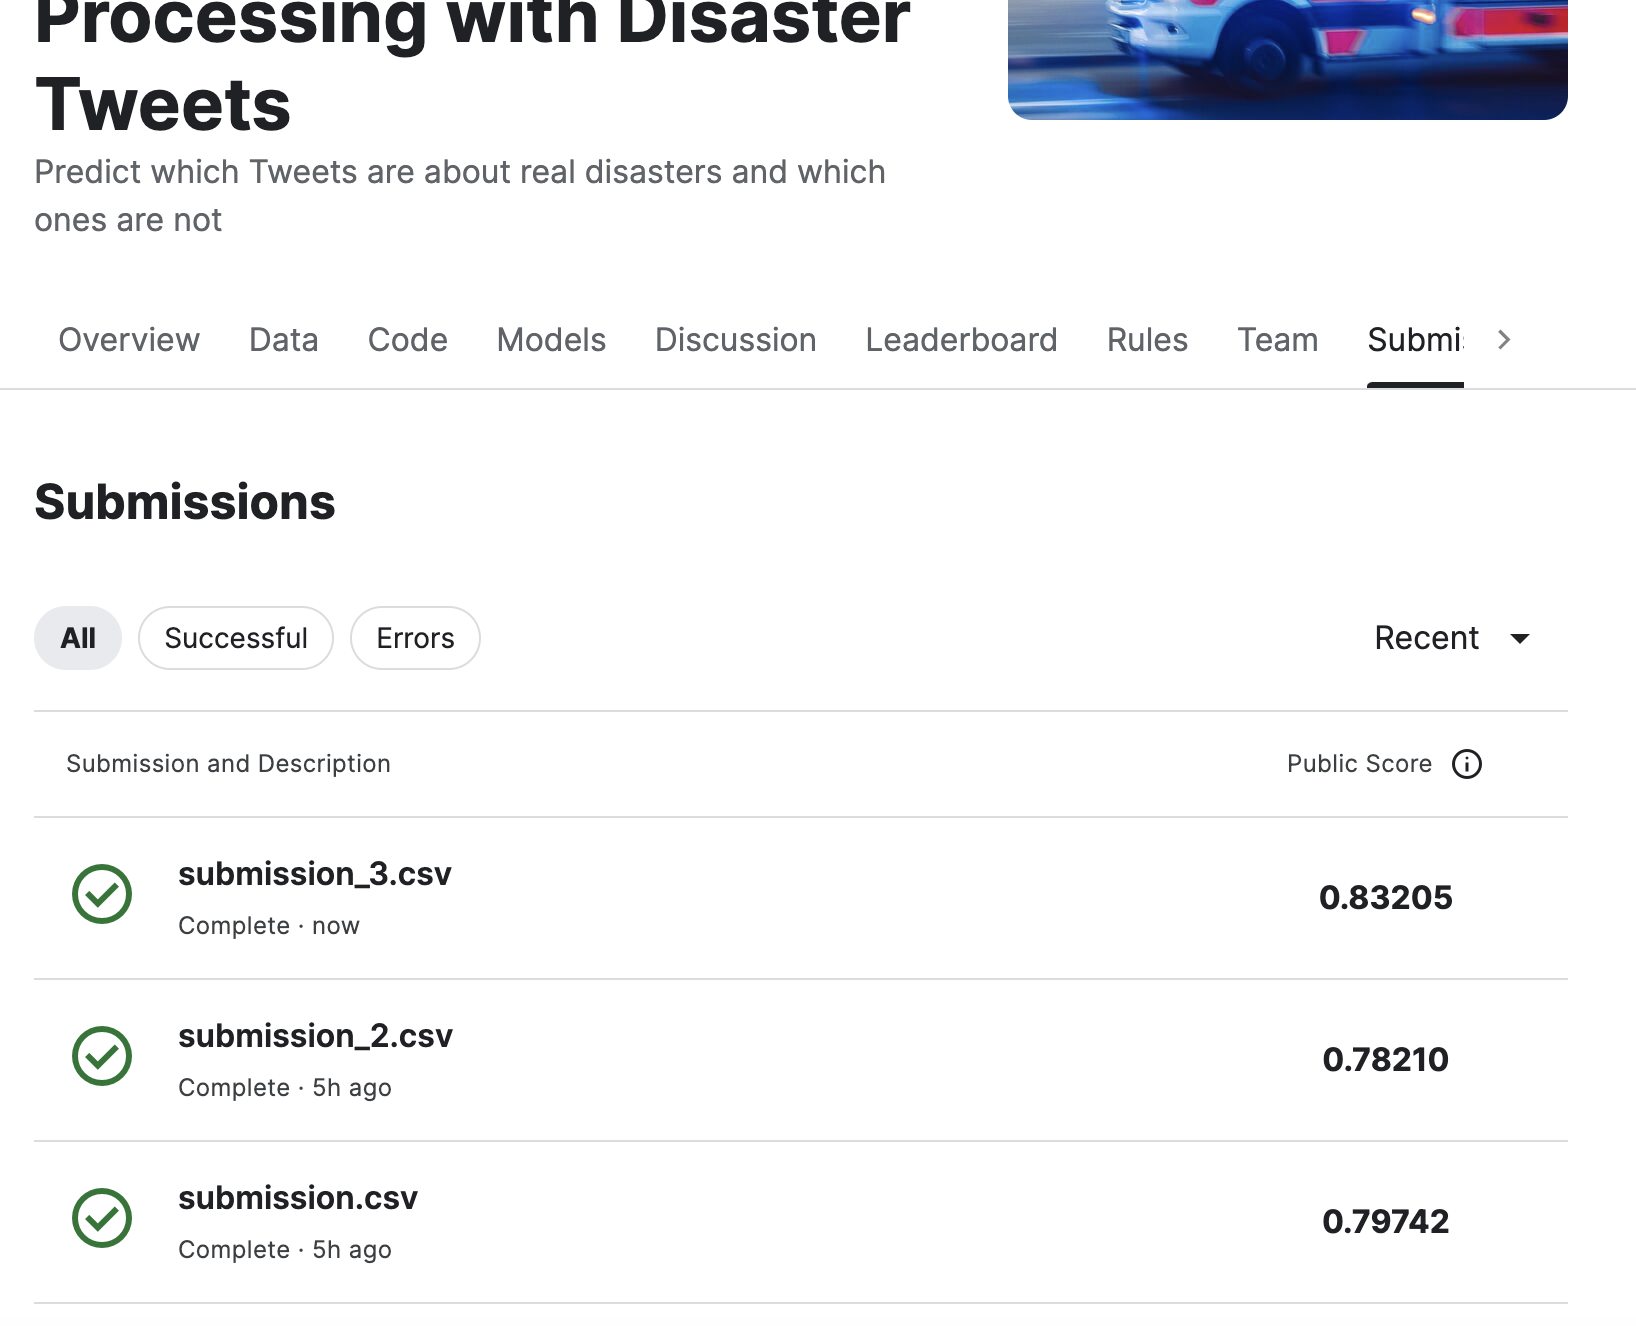

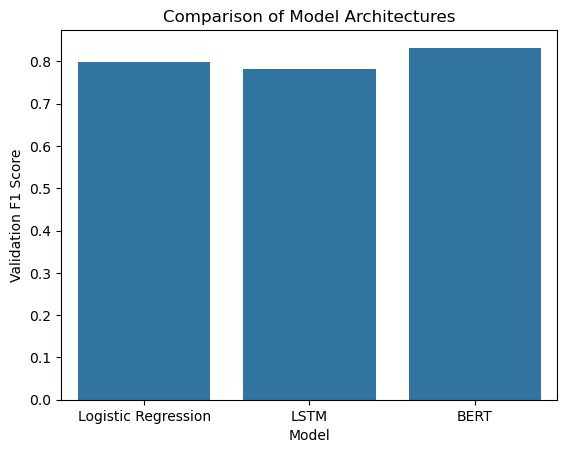

In [4]:
# Example of hyperparameter tuning results
results = {
    "Model": ["Logistic Regression", "LSTM", "BERT"],
    "Validation F1 Score": [0.79742, 0.78210, 0.83205]
}

results_df = pd.DataFrame(results)
sns.barplot(x="Model", y="Validation F1 Score", data=results_df)
plt.title("Comparison of Model Architectures")
plt.show()


# Conclusion

## Discussion of Results
The experiments conducted in this project demonstrate the effectiveness of different model architectures for the task of classifying disaster-related tweets. The BERT model, which leverages pre-trained language representations, achieved the highest F1 score, significantly outperforming the Logistic Regression and LSTM models.

## Learnings and Takeaways
- **Logistic Regression**: While simple and computationally efficient, this model may not capture complex patterns in text data as effectively as more advanced models.
- **LSTM**: Capable of capturing long-term dependencies, but requires careful tuning and significant computational resources.
- **BERT**: Pre-trained on a large corpus, it provides excellent performance by capturing rich contextual information from text data. Fine-tuning BERT for this specific task resulted in the best performance.

## Future Improvements
- **Further Hyperparameter Tuning**: Exploring a wider range of hyperparameters for the BERT model could potentially improve performance further.
- **Data Augmentation**: Augmenting the training data with more examples or using techniques like back-translation could enhance model robustness.
- **Advanced Architectures**: Experimenting with more recent transformer-based models or ensemble methods could yield better results.

## References
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Logistic Regression Explained](https://www.statisticssolutions.com/what-is-logistic-regression/)
